# Weekly Report 0627
This report includes:
1. Initializing sequence for LV5600, via telnet)
2. New method of extracting mid cyan pixels from the captured image
3. Mapping the mid cyan pixel position to cursor position
4. Mapping the cursor position to the corresponding mV value

In [11]:
# import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
from Constants import Constants

### Part 1: Initializing sequence for LV5600, via telnet


In [12]:
import logging
from commands import sys_command, wfm_command
from Constants import Constants
"""
    initialization sequence:
    1. SYS:INITIALIZE ALL
    2. WFM:LINE_SELECT ON
    3. WFM:LINE_NUMBER 580
    4. WFM:MATRIX:YCBCR RGB
    5. WFM:MODE:RGB:R OFF
    6. WFM:MODE:RGB:G ON
    7. WFM:MODE:RGB:B OFF
    8. WFM:CURSOR SINGLE
    9. WFM:CURSOR:DELTA 0
    10. WFM:CURSOR:REF 0
"""

async def lv5600_initialization(telnet_client):
    client = telnet_client
    # 1. SYS:INITIALIZE ALL
    try:
        response = await client.send_command(sys_command.system_initialize())
        logging.info("Initialized system")
    except Exception as e:
        raise LV5600InitializationError("Failed to initialize system")
    
    # 2. WFM:LINE_SELECT ON
    try:
        response = await client.send_command(wfm_command.wfm_line_select("ON"))
        logging.info("Turned on line select")
    except Exception as e:
        raise LV5600InitializationError("Failed to turn on line select")
    
    # 3. WFM:LINE_NUMBER 580
    try:
        response = await client.send_command(wfm_command.wfm_line_number(Constants.LINE_NUMBER))
        logging.info("Set line number to" + str(Constants.LINE_NUMBER))
    except Exception as e:
        raise LV5600InitializationError(f"Failed to set line number to {Constants.LINE_NUMBER}")
    
    # 4. WFM:MATRIX:YCBCR RGB
    try:
        response = await client.send_command(wfm_command.wfm_matrix_ycbcr("RGB"))
        logging.info("Set matrix to RGB")
    except Exception as e:
        raise LV5600InitializationError("Failed to set matrix to RGB")
    
    # 5. WFM:MODE:RGB:R OFF
    try:
        response = await client.send_command(wfm_command.wfm_mode_rgb("R", "OFF"))
        logging.info("Turned off R channel")
    except Exception as e:
        raise LV5600InitializationError("Failed to turn off R channel")
    
    # 6. WFM:MODE:RGB:G ON
    try:
        response = await client.send_command(wfm_command.wfm_mode_rgb("G", "ON"))
        logging.info("Turned on G channel")
    except Exception as e:
        raise LV5600InitializationError("Failed to turn on G channel")

    # 7. WFM:MODE:RGB:B OFF
    try:
        response = await client.send_command(wfm_command.wfm_mode_rgb("B", "OFF"))
        logging.info("Turned off B channel")
    except Exception as e:
        raise LV5600InitializationError("Failed to turn off B channel")
    
    # 8. WFM:CURSOR SINGLE
    try:
        response = await client.send_command(wfm_command.wfm_cursor("SINGLE"))
        logging.info("Set cursor to single")
    except Exception as e:
        raise LV5600InitializationError("Failed to set cursor to single")
    
    # 9. WFM:CURSOR:DELTA 0
    try:
        response = await client.send_command(wfm_command.wfm_cursor_height("Y","DELTA" , 0))
        logging.info("Set cursor delta to 0")
    except Exception as e:
        raise LV5600InitializationError("Failed to set cursor delta to 0")
    
    # 10. WFM:CURSOR:REF 0
    try:
        response = await client.send_command(wfm_command.wfm_cursor_height('Y', "REF" , 0))
        logging.info("Set cursor ref to 0")
    except Exception as e:
        raise LV5600InitializationError("Failed to set cursor ref to 0")

    # 11. WFM:CURSOR:UNIT:Y MV
    try:
        response = await client.send_command(wfm_command.wfm_cursor_unit("Y", "MV"))
        logging.info("Set cursor unit to MV")
    except Exception as e:
        raise LV5600InitializationError("Failed to set cursor unit to MV")

class LV5600InitializationError(Exception):
    pass

### Part 2: New method of extracting mid cyan pixels from the captured image
* The key idea here is that since we initialize the LV5600 everytime, we know exactly where the mid cyan pixel is. So we can just extract the column of mid cyan pixel from the absolute position

In [13]:
async def calculate_middle_cyan_y(image) -> float:
    lower_cyan_range = np.array([0, 200, 200])
    upper_cyan_range = np.array([100, 255, 255])

    # get cyan coordinates
    cyan_mask = cv2.inRange(image, lower_cyan_range, upper_cyan_range)
    cyan_coordinates = np.where(cyan_mask == 255)
    cyan_coordinates = np.array(cyan_coordinates)

    mid_point_x = int(image.shape[1]/2)
    mid_cyan_pixels = np.where(cyan_coordinates[1] == mid_point_x)[0]
    mid_cyan_y = np.nanmin(cyan_coordinates[0][mid_cyan_pixels]) # this extract the minimum y value of the middle cyan pixels
    return mid_cyan_y

### Part 3: Mapping the mid cyan pixel position to cursor position

In [14]:
average_count = 5
from scripts import capture_and_send_bmp

async def capture_classify_show_with_initialize(telnet_client, ftp_client):
    try:    
        try:
            await lv5600_initialization(telnet_client)
            logging.info("LV5600 initialized.")
        except LV5600InitializationError as e:
            logging.error("LV5600 Initialization error: "+str(e))
            return
        except Exception as e:
            logging.error(f"An unexpected error occurred: {e}")
            return

        # turn off the WFM SCALE
        try:
            response = await telnet_client.send_command(wfm_command.wfm_scale_inten(-8))
            logging.info("Turned off WFM SCALE")
        except Exception as e:
            logging.error(f"An unexpected error occurred: {e}")
            return
        

        cyan_y_values = []
        for i in range(average_count): # replace N with number of screenshots
            # capture the image
            try:
                await capture_and_send_bmp(telnet_client, ftp_client)
                logging.info(f"Captured and sent bmp {i+1}.")
            except Exception as e:
                logging.error(f"Failed to capture and send bmp: {e}")
                continue
            image = cv2.imread(Constants.LOCAL_FILE_PATH_BMP)
            if image is None:
                logging.error("Image is None")
                return
        
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image[Constants.WFM_ROI_COORDINATES_X1:Constants.WFM_ROI_COORDINATES_X2, Constants.WFM_ROI_COORDINATES_Y1:Constants.WFM_ROI_COORDINATES_Y2]

            mid_cyan_y = await calculate_middle_cyan_y(image)
            if np.isnan(mid_cyan_y):
                logging.warning(f"No cyan pixel in the middle for image {i+1}")
                continue

            cyan_y_values.append(mid_cyan_y)
            logging.info(f"Middle cyan pixel's y value for image {i+1}: {mid_cyan_y}")

        # calculate average y value
        average_y = np.mean(cyan_y_values)
        logging.info(f"Average y value: {average_y}")

        # calculate target level
        target_level = (1-average_y/float(image.shape[0]))* 11000 
        target_level = int(target_level)

        # tune WFM Cursor to target level
        try:
            logging.info(f"Peak level: {target_level}")
            response = await telnet_client.send_command(wfm_command.wfm_cursor_height('Y',"DELTA",target_level))
            logging.info("Tuned WFM Cursor to peak level")
        except Exception as e:
            logging.error(f"An unexpected error occurred: {e}")
            return


    finally:
        logging.info("Set WFM Cursor to peak level.")

    cursor_height = target_level
    mv_value = 0.07*cursor_height
    logging.info(f"Current MV value: {mv_value}")
    if(mv_value > 769.5):
        # oversaturated
        class_ = "Oversaturated"
    elif(766.5<=mv_value <= 769.5):
        # saturated
        class_ = "Saturated"
    elif(0<=mv_value < 766.5):
        # undersaturated
        class_ = "Undersaturated"
    else:
        logging.error("Unknown saturation level")
        class_ = "Unknown"
    
    # turn back on the WFM SCALE
    try:
        response = await telnet_client.send_command(wfm_command.wfm_scale_inten(0))
        logging.info("Turned on WFM SCALE")
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return
    
    return class_, mv_value


# Part 4: Mapping the cursor position to the corresponding mV value
* This part is easy math mapping, since we have the exact ROI coordinates, we can just map the cursor position to the corresponding mV value
* We know when Cursor is 0, mV is 0, and when Cursor is 11000, mV is 770

### Part 5: Putting everything together, a demo with local image

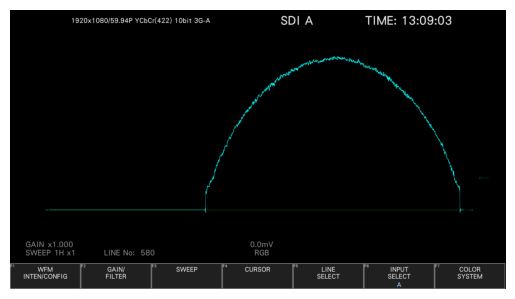

In [15]:
# load the image
image =cv2.imread(Constants.LOCAL_FILE_PATH_BMP)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# display the image
plt.imshow(image)
plt.axis("off")
plt.show()

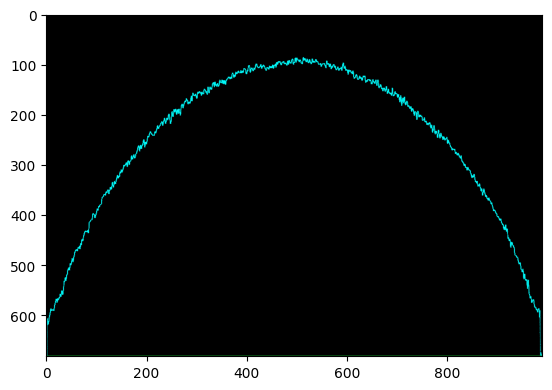

In [16]:
# crop the image
image = image[Constants.WFM_ROI_COORDINATES_X1:Constants.WFM_ROI_COORDINATES_X2, Constants.WFM_ROI_COORDINATES_Y1:Constants.WFM_ROI_COORDINATES_Y2]
plt.imshow(image)

In [17]:
# call the function in Part1 to get the min y value of the middle cyan pixels
mid_cyan_y = await calculate_middle_cyan_y(image)
if np.isnan(mid_cyan_y):
    logging.warning("No cyan pixel in the middle")

# calculate target level
target_level = (1-mid_cyan_y/float(image.shape[0]))* 11000
target_level = int(target_level)

mv_value = 0.07*target_level
print(f"Current MV value: {mv_value}")


Current MV value: 662.69
